# Welcome to the tutorial for motor imagery analysis with Medusa

Motor imagery (MI) is a mental task where a subject imagines performing a movement without actually executing it. This task is commonly used in brain-computer interface (BCI) systems to control devices such as a cursor on a screen or a robotic arm. In this tutorial, we will use the Medusa library to analyze motor imagery data and train a classifier to distinguish between left and right hand movements. We will use the Common Spatial Pattern (CSP) algorithm to extract spatial features from the EEG signals and train a linear classifier to predict the movement class. The goal is to train a classifier that can distinguish between left and right hand movements based on the EEG signals.

In this notebook, we will:
- Load and visualize motor imagery data.
- Create frequency and time-domain plots for two EEG channels.
- Train a CSP (Common Spatial Pattern) model and evaluate its performance using k-fold cross-validation.
- Plot the CSP filters to examine the learned spatial patterns.
- Saving the model for future use
- Loading the model and using it to predict new data

## The MI-based paradigm

### Experiment briefing
In this tutorial, we will work with pre-recorded data from a user
participating in a MI experiment using the
[MI app](https://www.medusabci.com/market/mi) app from [MEDUSA©](https://www.medusabci.com).

The objective of the experiment was to control a ball that could move left
and right. The user was instructed to imagine moving their left or right
hand. There are 10 trials for each run with a duration of 6 seconds per
trial. There are 10 runs in total with 4 corresponding to calibration and 6
to testing offering feedback.

The EEG data were recorded from 16 active channels positioned at 'F3', 'FZ',
 'F4', 'C3', 'CZ', 'C4', 'CPZ', 'P3', 'PZ', 'P4', 'PO7', 'POZ', 'PO8', 'OZ',
  'I1',and 'I2' , with a sampling rate of 256 Hz.

### Load calibration and test data
First, if you are using Google Colab, execute the following cell to install `medusa-kernel` and clone the GitHub repository to obtain the EEG recordings.

<div class="alert alert-block alert-danger">
Important: execute the following cell **only** if you're using Google Collab!
</div>

In [ ]:
!pip install medusa-kernel
!git clone https://github.com/medusabci/medusa-tutorials.git

Now we need to import the required libraries

In [5]:
# General imports
from medusa.plots import mi_plots
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import glob

# Medusa imports
from medusa.components import Recording
from medusa.bci.mi_paradigms import MIModelCSP, MIDataset

print('\n> All required packages were successfully imported')


> All required packages were successfully imported


### Loading Data
We start by loading the dataset containing motor imagery recordings.

In [6]:
# Load calibration data and test data
files_train = glob.glob("mi/*train*.mi.bson")
files_test = glob.glob("mi/*test*.mi.bson")

# Initialize the MIPlots object for plotting
miplots = mi_plots.MIPlots()
miplots.set_sizes(label_size=6, axes_size=5, line_width=1)

# We will use one of the files for plotting relevant data
miplots.set_dataset([files_test[0]])

# Define EEG channels to plot
ch1 = 'C3'
ch2 = 'C4'

# Define windows for baseline and epoch (relative to the onset of the cue)
w_baseline = (-2000, 0)
w_epoch = (500, 6000)

Explanation:

We are using the glob library to gather a list of files containing motor imagery recordings.
The dataset is then set up using the MIPlots object, where we specify the 
channels C3 and C4 for plotting.
Windows for the baseline and epoch are defined to extract relevant portions of the data around the motor imagery cue.

### Plotting Frequency-Domain Data
Now, we plot the event-related desynchronization/synchronization (ERD/ERS) in the frequency domain.

Extracting features: 100%|██████████| 1/1 [00:00<00:00, 562.24it/s]
C:\Users\edusa\AppData\Local\Temp\ipykernel_17716\3620727951.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


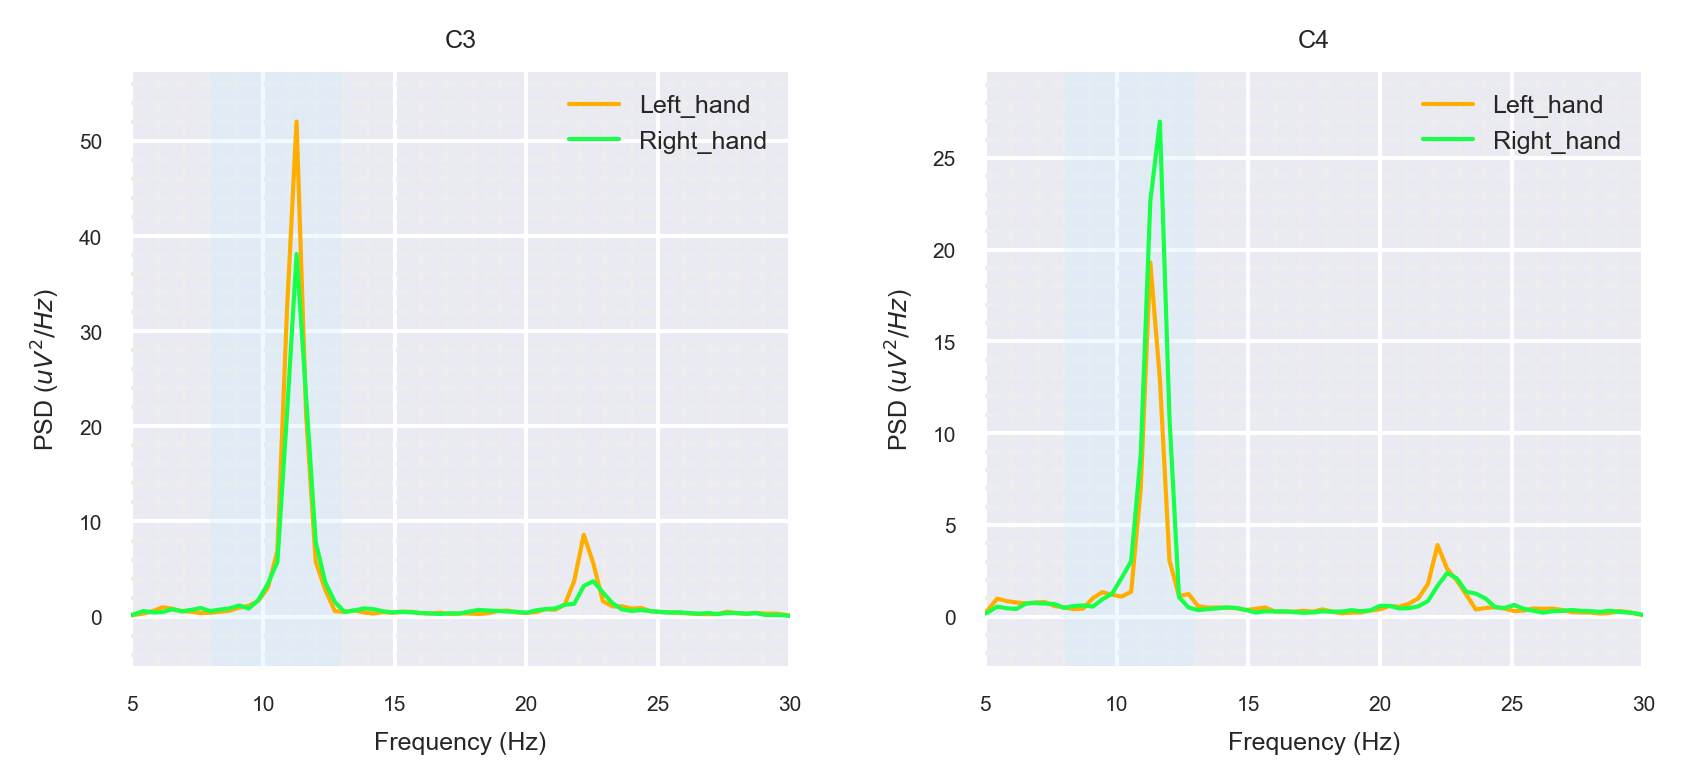

In [7]:
# Prepare the figure
fig = plt.figure(figsize=(5.5, 2.5), dpi=300, layout='constrained')
gs = fig.add_gridspec(1, 2, wspace=0.1, hspace=0.1)

# Frequency plots
freq_axs_dict = list()
freq_axs_dict.append({'freq': fig.add_subplot(gs[0:6, 0])})
freq_axs_dict.append({'freq': fig.add_subplot(gs[0:6, 1])})

freq_axs_dict = miplots.plot_erd_ers_freq(
    ch_to_plot=(ch1, ch2),
    axs_to_plot=freq_axs_dict,
    f_lims=(5, 30),
    f_sel=(8, 13),
    t_trial_window=w_epoch
)

fig.show()

Explanation:
The plot_erd_ers_freq method is used to visualize frequency-specific power changes over time for channels C3 and C4.

### Training the CSP Model
In this section, we will configure and train a traditional Common Spatial Pattern (CSP) model using the motor imagery data.

In [8]:
# Define settings for the CSP model
settings = {
        'p_filt_cutoff': (8, 30),
        'n_filters': 2,
        'normalize_log_vars': False,
        'w_epoch_t': w_epoch,
        'baseline_mode': 'sliding',
        'w_baseline_t': w_baseline,
        'norm': 'z',
        'target_fs': None,
        'concatenate_channels': False,
        'sliding_w_lims_t': w_epoch,
        'sliding_t_step': 200,
        'sliding_win_len': 2000
    }

# Initialize and configure the CSP model
model = MIModelCSP()
model.configure(**settings)
model.build()

# Load dataset and add recordings
for i, _file in enumerate(files_train):
    rec = Recording.load(_file)
    if i == 0:
        dataset = MIDataset(channel_set=rec.eeg.channel_set, fs=rec.eeg.fs, experiment_mode='train')
    dataset.add_recordings(rec)

Explanation:

The CSP model settings are defined, including parameters for frequency filtering and windowing.
The dataset is then loaded, and recordings are added to the MIDataset object.

### Cross-Validation and Model Performance
We now evaluate the model's performance using k-fold cross-validation.

In [9]:
# Perform k-fold cross-validation
k_fold = 5
fit_results = model.fit_dataset(dataset, k_fold=k_fold)

# Print cross-validation results
print(f"Estimating accuracy using {k_fold}-fold cross-validation")
for k in range(k_fold):
    print(f"Fold {k + 1}: {fit_results['k-fold'][k]['accuracy']*100:.2f}%")
print(f"Estimated accuracy: {fit_results['accuracy'] * 100:.2f}%")


Extracting features: 100%|██████████| 4/4 [00:00<00:00, 30.63it/s]


Estimating accuracy using 5-fold cross-validation
Fold 1: 68.06%
Fold 2: 65.97%
Fold 3: 76.39%
Fold 4: 80.56%
Fold 5: 87.50%
Estimated accuracy: 75.69%


Explanation:

We use 5-fold cross-validation to estimate the model's accuracy.
The accuracy for each fold is printed, along with the overall estimated 
accuracy from the model trained on all the data.

### Plotting CSP Filters
Finally, we visualize the spatial patterns learned by the CSP model.

C:\Users\edusa\AppData\Local\Temp\ipykernel_17716\1099213759.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_CSP.show()


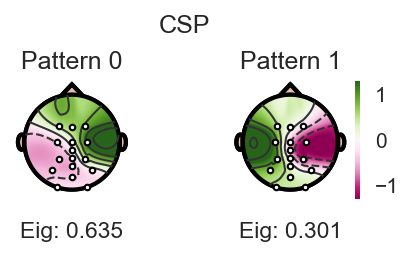

In [10]:
# Plot the CSP model's filters
fig_CSP = plt.figure(figsize=(3, 1.6), dpi=150, layout='constrained')
model.methods["ext_method"]['instance'].CSP.plot(
    channel_set=model.channel_set,
    plot_filters=False,
    plot_patterns=True,
    show=False, 
    figure=fig_CSP,
    only_selected=True
)

# Display the figure
fig_CSP.show()

Explanation:

The spatial filters (patterns) learned by the CSP model that are selected 
for classification are plotted.
These patterns help us interpret the spatial distribution that the model 
extracts to distinguish between motor imagery of the left and right hand. 


### Save and load a model then predict dataset accuracy
In this final part of the code, we will cover how to save the trained CSP model, reload it, and use it to make predictions on new data.

#### Saving the Trained Model
After training the CSP model, it's important to save it for future use. This step allows you to store the trained model parameters so that you can apply the model to new datasets or use it in your BCI experiments without retraining it every time. Here, we save the trained model using the save method:

In [11]:
# Save the model
model.save('model_train.csp.mi.mdl')
print('Model saved successfully!')

Model saved successfully!


#### Loading the Saved Model
To use the saved model, we first need to load it from the saved file. This allows us to apply the previously trained model to a new dataset.

In [12]:
# Load the saved model
model_loaded = MIModelCSP.load('model_train.csp.mi.mdl')
print('Model loaded successfully!')

Model loaded successfully!


#### Predicting on New Data
Now that we have loaded the model, we can use it to make predictions on a new dataset (files_test). This part simulates the process of applying the CSP model to unseen data to assess its performance in a real-world scenario.

In [13]:
# Load the test data and prepare the dataset for prediction
for i, _file in enumerate(files_test):
    rec = Recording.load(_file)
    if i == 0:
        dataset_test = MIDataset(
            channel_set=rec.eeg.channel_set,
            fs=rec.eeg.fs,
            experiment_mode='train'
        )
    dataset_test.add_recordings(rec)

# Use the loaded model to make predictions
predict_results = model_loaded.predict_dataset(dataset_test)
print(f"\n Model accuracy: {predict_results['accuracy'] * 100:.2f}%")

Extracting features: 100%|██████████| 4/4 [00:00<00:00, 30.27it/s]


 Model accuracy: 71.81%


Explanation:

The predict_dataset method uses the loaded CSP model to predict labels for the new data. It computes the model’s accuracy based on how well the predictions match the true labels in the test dataset.
The prediction accuracy is printed, giving us an indication of the model’s performance on unseen data.